In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import glob
import os

path = "/content/drive/MyDrive/Andaman_Rainfall_Analytics/CHIRPS_Andaman_Data"
all_files = glob.glob(os.path.join(path, "CHIRPS_*.csv"))

df_list = []
for file in all_files:
    temp_df = pd.read_csv(file)
    temp_df['source_file'] = os.path.basename(file)
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

print("Total records loaded:", len(df))
print("Columns:", df.columns.tolist())
df.head()

df.to_csv("/content/drive/MyDrive/Andaman_Rainfall_Analytics/merged_CHIRPS.csv", index=False)

Total records loaded: 1341897
Columns: ['system:index', 'count', 'date', 'label', 'precipitation', '.geo', 'source_file']


In [3]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Andaman_Rainfall_Analytics/merged_CHIRPS.csv")

df_clean = df.dropna(subset=['precipitation'])
df_clean = df_clean[df_clean['precipitation'] != 0]

df_clean = df_clean.drop(columns=['system:index'])

df_clean.to_csv("/content/drive/MyDrive/Andaman_Rainfall_Analytics/CHIRPS_Cleaned.csv", index=False)

print("Cleaned CSV saved!")
print("Rows after cleaning:", len(df_clean))
print("Saved to: CHIRPS_Cleaned.csv")

Cleaned CSV saved!
Rows after cleaning: 432622
Saved to: CHIRPS_Cleaned.csv


In [4]:
import pandas as pd
import json

df = pd.read_csv("/content/drive/MyDrive/Andaman_Rainfall_Analytics/CHIRPS_Cleaned.csv")

df = df.dropna(subset=['precipitation'])
df = df[df['precipitation'] != 0]

df = df.drop(columns=[col for col in ['count', 'source_file'] if col in df.columns])

def extract_lat_lon(geo_str):
    try:
        geo_str_clean = geo_str.replace('false', 'False')
        geo = eval(geo_str_clean)
        coords = geo['coordinates']
        return pd.Series({'longitude': coords[0], 'latitude': coords[1]})
    except Exception as e:
        print("Failed to parse:", geo_str)
        return pd.Series({'longitude': None, 'latitude': None})

coords = df['.geo'].apply(extract_lat_lon)
df = pd.concat([df, coords], axis=1)

df = df.drop(columns=['.geo'])

df = df.dropna(subset=['latitude', 'longitude'])

df.to_csv("/content/drive/MyDrive/Andaman_Rainfall_Analytics/CHIRPS_Cleaned1.csv", index=False)

print("Cleaned and georeferenced CSV saved!")
print(df.head())

Cleaned and georeferenced CSV saved!
         date   label  precipitation  longitude  latitude
0  2024-01-01  932125      28.520353  93.649293  7.262650
1  2024-01-01  510309      24.494017  93.649293  7.307566
2  2024-01-01  805995      20.175045  93.649293  7.352482
3  2024-01-01  131429      14.772869  93.694209  7.127903
4  2024-01-01  292062      26.981068  93.694209  7.172819


In [5]:
df.head()

,date,label,precipitation,longitude,latitude
0,2024-01-01,932125,28.520353,93.649293,7.262650
1,2024-01-01,510309,24.494017,93.649293,7.307566
2,2024-01-01,805995,20.175045,93.649293,7.352482
3,2024-01-01,131429,14.772869,93.694209,7.127903
4,2024-01-01,292062,26.981068,93.694209,7.172819


# **RAINFALL ANOMALY DETECTION**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Andaman_Rainfall_Analytics/CHIRPS_Cleaned1.csv")

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

In [9]:
df.head()

,date,label,precipitation,longitude,latitude,Year,Month
0,2024-01-01,932125,28.520353,93.649293,7.262650,2024,1
1,2024-01-01,510309,24.494017,93.649293,7.307566,2024,1
2,2024-01-01,805995,20.175045,93.649293,7.352482,2024,1
3,2024-01-01,131429,14.772869,93.694209,7.127903,2024,1
4,2024-01-01,292062,26.981068,93.694209,7.172819,2024,1


In [10]:
print("Data Range:", df['date'].min(), "to", df['date'].max())
print("Years Covered:", sorted(df['Year'].unique()))

Data Range: 2013-01-01 00:00:00 to 2024-12-30 00:00:00
Years Covered: [np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


In [11]:
print(df.columns)

Index(['date', 'label', 'precipitation', 'longitude', 'latitude', 'Year',
       'Month'],
      dtype='object')


**MONTHLY ANOMALIES**

In [12]:
monthly_total_precip = df.groupby(['Year', 'Month'])['precipitation'].sum().reset_index()
monthly_total_precip.rename(columns={'precipitation': 'monthly_total_precip'}, inplace=True)

monthly_mean_precip = df.groupby(['Year', 'Month'])['precipitation'].mean().reset_index()
monthly_mean_precip.rename(columns={'precipitation': 'monthly_mean_precip'}, inplace=True)

monthly_climatology = monthly_mean_precip.groupby('Month')['monthly_mean_precip'].mean().reset_index()
monthly_climatology.rename(columns={'monthly_mean_precip': 'climatological_monthly_mean'}, inplace=True)

month_to_clim_mean = dict(zip(monthly_climatology['Month'], monthly_climatology['climatological_monthly_mean']))
monthly_mean_precip['monthly_anomaly'] = monthly_mean_precip.apply(
    lambda row: row['monthly_mean_precip'] - month_to_clim_mean[row['Month']], axis=1
)

df = pd.merge(df, monthly_total_precip, on=['Year', 'Month'], how='left')
df = pd.merge(df, monthly_mean_precip[['Year', 'Month', 'monthly_mean_precip', 'monthly_anomaly']], on=['Year', 'Month'], how='left')

print("\nDataFrame with Monthly Total, Mean, and Anomaly:")
print(df.tail(12))
print("\nClimatological Monthly Mean:")
print(monthly_climatology)


DataFrame with Monthly Total, Mean, and Anomaly:
             date   label  precipitation  longitude   latitude  Year  Month  \
432610 2015-12-26  486135       7.438367  92.526399  10.766080  2015     12   
432611 2015-12-26  796218       5.867620  92.526399  10.810996  2015     12   
432612 2015-12-26  702350       6.501957  92.526399  10.855911  2015     12   
432613 2015-12-26  810145       4.403138  92.571315  10.676248  2015     12   
432614 2015-12-26  378788       5.621754  92.571315  10.721164  2015     12   
432615 2015-12-26  827782       4.075691  92.571315  10.766080  2015     12   
432616 2015-12-26  793155       8.398064  92.930641  13.461026  2015     12   
432617 2015-12-26  273746       6.218037  92.930641  13.505942  2015     12   
432618 2015-12-26  317263      10.725218  92.975557  13.371194  2015     12   
432619 2015-12-26  186227       5.553666  92.975557  13.505942  2015     12   
432620 2015-12-26  507205       7.253965  93.020473  13.461026  2015     12   
43

In [13]:
print("\nMonthly Mean Precipitation for Each Year:")
print(monthly_mean_precip.groupby('Year')['monthly_mean_precip'].mean())



Monthly Mean Precipitation for Each Year:
Year
2013    23.822311
2014    21.775037
2015    21.933167
2016    22.081856
2017    26.790172
2018    27.287774
2019    24.951754
2020    23.504065
2021    26.503752
2022    22.126862
2023    20.414449
2024    23.551187
Name: monthly_mean_precip, dtype: float64


In [14]:
monthly_mean_precip.to_csv("/content/drive/MyDrive/CHIRPS_Monthly_Anomalies.csv", index=False)

**ANNUAL ANOMALIES**

In [15]:
annual_total = df.groupby('Year')['precipitation'].sum().reset_index()
annual_total.rename(columns={'precipitation': 'annual_total_precip'}, inplace=True)

annual_mean = df.groupby('Year')['precipitation'].mean().reset_index()
annual_mean.rename(columns={'precipitation': 'annual_mean_precip'}, inplace=True)

climatological_mean_total = annual_total['annual_total_precip'].mean()
annual_total['annual_total_anomaly'] = annual_total['annual_total_precip'] - climatological_mean_total

df = pd.merge(df, annual_total[['Year', 'annual_total_precip', 'annual_total_anomaly']], on='Year', how='left')
df = pd.merge(df, annual_mean, on='Year', how='left')

print("\nClimatological Annual Total Mean:", round(climatological_mean_total, 2))

print("\nFinal DataFrame with Annual Stats:")
print(df.tail(8))


Climatological Annual Total Mean: 956615.56

Final DataFrame with Annual Stats:
             date   label  precipitation  longitude   latitude  Year  Month  \
432614 2015-12-26  378788       5.621754  92.571315  10.721164  2015     12   
432615 2015-12-26  827782       4.075691  92.571315  10.766080  2015     12   
432616 2015-12-26  793155       8.398064  92.930641  13.461026  2015     12   
432617 2015-12-26  273746       6.218037  92.930641  13.505942  2015     12   
432618 2015-12-26  317263      10.725218  92.975557  13.371194  2015     12   
432619 2015-12-26  186227       5.553666  92.975557  13.505942  2015     12   
432620 2015-12-26  507205       7.253965  93.020473  13.461026  2015     12   
432621 2015-12-26  873432       8.315499  93.020473  13.505942  2015     12   

        monthly_total_precip  monthly_mean_precip  monthly_anomaly  \
432614          34312.163567            20.871146        -4.214022   
432615          34312.163567            20.871146        -4.214022 

**SEASONAL RAINFALL ANOMALIES**

In [16]:
import pandas as pd

df['date'] = pd.to_datetime(df['date'])
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

def assign_season(month):
    if month in [1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Pre-monsoon'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-monsoon'

df['Season'] = df['Month'].apply(assign_season)

# Step 2: Compute daily spatial mean precipitation
daily_mean = df.groupby(['date', 'Year', 'Season'])['precipitation'].mean().reset_index()

# Step 3: Compute seasonal total precipitation from daily means
seasonal_precip = daily_mean.groupby(['Year', 'Season'])['precipitation'].sum().reset_index()
seasonal_precip.rename(columns={'precipitation': 'seasonal_total_precip'}, inplace=True)

# Step 4: Compute climatological mean for each season
seasonal_mean = seasonal_precip.groupby('Season')['seasonal_total_precip'].mean().reset_index()
seasonal_mean.rename(columns={'seasonal_total_precip': 'climatological_mean_precip'}, inplace=True)

# Step 5: Compute seasonal anomalies
seasonal_anomalies = []
for _, row in seasonal_precip.iterrows():
    season = row['Season']
    year = row['Year']
    total = row['seasonal_total_precip']
    climatological_mean = seasonal_mean.loc[seasonal_mean['Season'] == season, 'climatological_mean_precip'].values[0]
    anomaly = total - climatological_mean
    seasonal_anomalies.append({
        'Year': year,
        'Season': season,
        'seasonal_total_precip': total,
        'climatological_mean_precip': climatological_mean,
        'seasonal_anomaly': anomaly
    })

seasonal_anomaly_df = pd.DataFrame(seasonal_anomalies)

# Step 5: Merge seasonal anomalies into original df
df = pd.merge(df, seasonal_anomaly_df, on=['Year', 'Season'], how='left')

print("\nSeasonal Precipitation Anomalies (Sample):")
print(seasonal_anomaly_df.head(12))

print("\nClimatological Seasonal Mean Precipitation:")
print(seasonal_mean)

print("\nDataFrame with Seasonal Anomalies (Sample):")
print(df.tail())


Seasonal Precipitation Anomalies (Sample):
    Year        Season  seasonal_total_precip  climatological_mean_precip  \
0   2013       Monsoon            2747.118632                 3268.576565   
1   2013  Post-monsoon            2070.074976                 1829.452532   
2   2013   Pre-monsoon             993.071431                  840.359767   
3   2013        Winter             483.099684                  444.118614   
4   2014       Monsoon            3503.188973                 3268.576565   
5   2014  Post-monsoon            1850.186061                 1829.452532   
6   2014   Pre-monsoon             623.811038                  840.359767   
7   2014        Winter             261.783412                  444.118614   
8   2015       Monsoon            2306.479730                 3268.576565   
9   2015  Post-monsoon            1667.844438                 1829.452532   
10  2015   Pre-monsoon             931.746551                  840.359767   
11  2015        Winter          

In [17]:
df.head()

,date,label,precipitation,longitude,latitude,Year,Month,monthly_total_precip,monthly_mean_precip,monthly_anomaly,annual_total_precip,annual_total_anomaly,annual_mean_precip,Season,seasonal_total_precip,climatological_mean_precip,seasonal_anomaly
0,2024-01-01,932125,28.520353,93.649293,7.262650,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514
1,2024-01-01,510309,24.494017,93.649293,7.307566,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514
2,2024-01-01,805995,20.175045,93.649293,7.352482,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514
3,2024-01-01,131429,14.772869,93.694209,7.127903,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514
4,2024-01-01,292062,26.981068,93.694209,7.172819,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514


# **RAINFALL TREND ANALYSIS**

In [18]:
!pip install pymannkendall --quiet

In [19]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import pymannkendall as mk

In [20]:
annual_mean_df = df[['Year', 'annual_mean_precip']].drop_duplicates().reset_index(drop=True)
print(annual_mean_df.head())

   Year  annual_mean_precip
0  2024           27.608950
1  2023           24.107293
2  2018           28.036570
3  2014           25.175888
4  2021           30.259818


In [21]:
slope, intercept, r_value, p_value, std_err = linregress(
    annual_mean_df['Year'], annual_mean_df['annual_mean_precip']
)

In [22]:
print("Annual Mean Rainfall Summary:")
print(annual_mean_df)

Annual Mean Rainfall Summary:
    Year  annual_mean_precip
0   2024           27.608950
1   2023           24.107293
2   2018           28.036570
3   2014           25.175888
4   2021           30.259818
5   2019           29.554798
6   2016           26.189968
7   2013           25.827894
8   2020           26.773332
9   2022           24.036479
10  2017           26.949865
11  2015           23.685295


In [23]:
print(f"\nLinear Trend Line: y = {slope:.2f}x + {intercept:.2f}")
print(f"R²: {r_value**2:.4f}, p-value: {p_value:.4f}")


Linear Trend Line: y = 0.12x + -211.82
R²: 0.0404, p-value: 0.5310


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [25]:
seasonal_avg_df = seasonal_anomaly_df[['Year', 'Season', 'seasonal_total_precip']].drop_duplicates().reset_index(drop=True)

seasonal_pivot = seasonal_avg_df.pivot(index='Year', columns='Season', values='seasonal_total_precip')

print(seasonal_avg_df.head())
print("\nPivoted Seasonal Totals:")
print(seasonal_pivot.head())

   Year        Season  seasonal_total_precip
0  2013       Monsoon            2747.118632
1  2013  Post-monsoon            2070.074976
2  2013   Pre-monsoon             993.071431
3  2013        Winter             483.099684
4  2014       Monsoon            3503.188973

Pivoted Seasonal Totals:
Season      Monsoon  Post-monsoon  Pre-monsoon      Winter
Year                                                      
2013    2747.118632   2070.074976   993.071431  483.099684
2014    3503.188973   1850.186061   623.811038  261.783412
2015    2306.479730   1667.844438   931.746551  434.330579
2016    3208.257018   1784.633053   727.942327  485.410154
2017    3547.908703   2019.722086   676.931881  504.271287


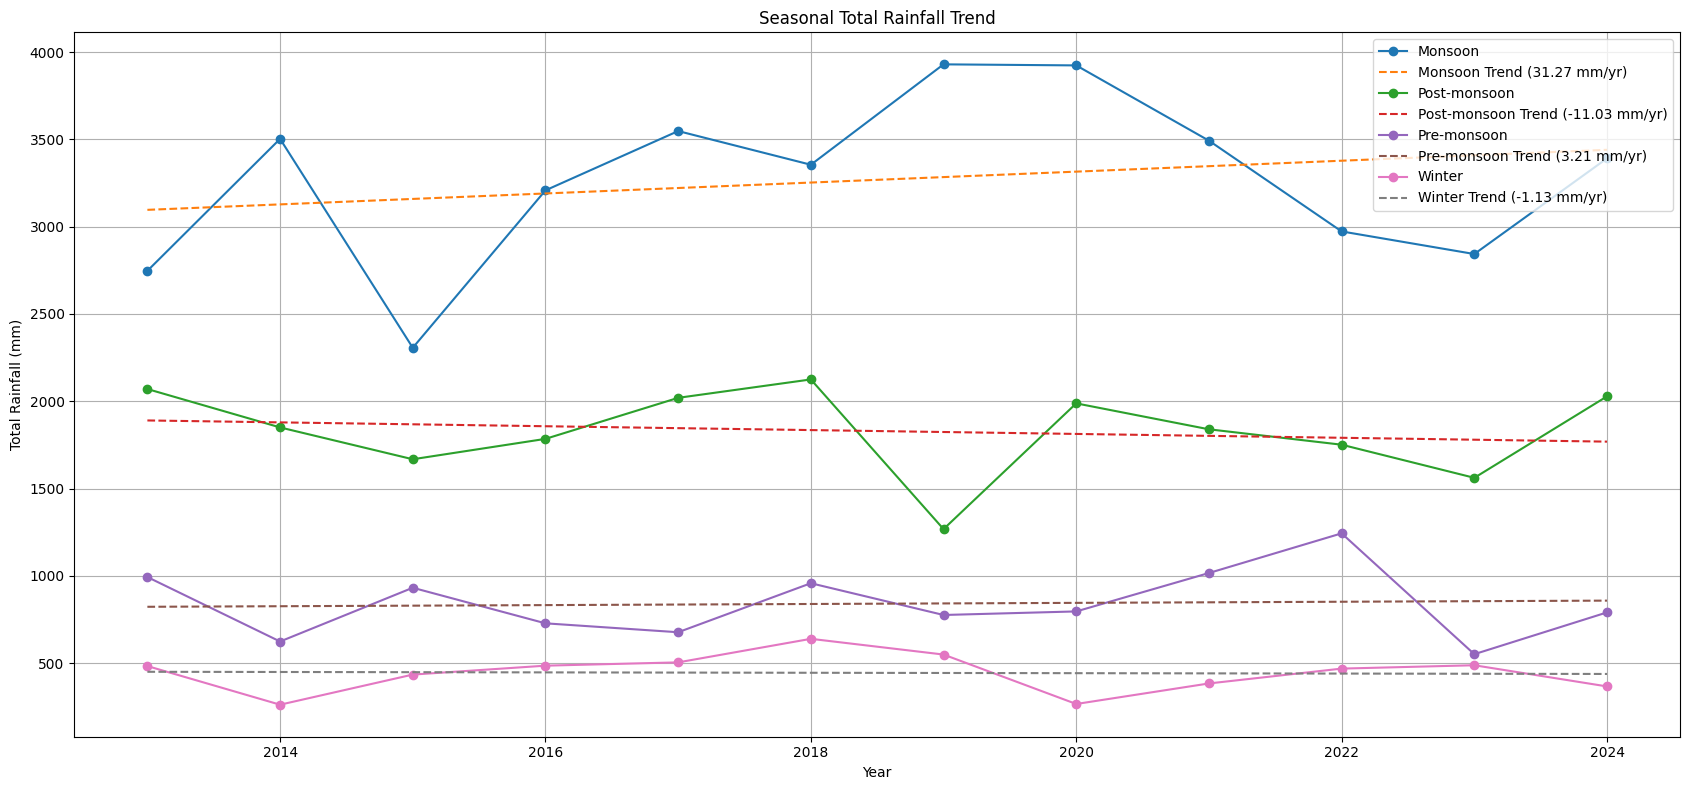

In [26]:
plt.figure(figsize=(17, 8))

for season in seasonal_pivot.columns:
    x = seasonal_pivot.index
    y = seasonal_pivot[season]

    plt.plot(x, y, label=season, marker='o')

    mask = ~np.isnan(y)
    if np.sum(mask) > 1:
        slope, intercept, _, _, _ = linregress(x[mask], y[mask])
        trend = slope * x + intercept
        plt.plot(x, trend, linestyle='--', label=f'{season} Trend ({slope:.2f} mm/yr)')

plt.title("Seasonal Total Rainfall Trend")
plt.xlabel("Year")
plt.ylabel("Total Rainfall (mm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
df.head()

,date,label,precipitation,longitude,latitude,Year,Month,monthly_total_precip,monthly_mean_precip,monthly_anomaly,annual_total_precip,annual_total_anomaly,annual_mean_precip,Season,seasonal_total_precip,climatological_mean_precip,seasonal_anomaly
0,2024-01-01,932125,28.520353,93.649293,7.262650,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514
1,2024-01-01,510309,24.494017,93.649293,7.307566,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514
2,2024-01-01,805995,20.175045,93.649293,7.352482,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514
3,2024-01-01,131429,14.772869,93.694209,7.127903,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514
4,2024-01-01,292062,26.981068,93.694209,7.172819,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514


# **RAINFALL INTENSITY AND FREQUENCY ANALYSIS**

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

df['rainy_day'] = df['precipitation'] >= 2.5

In [30]:
def assign_season(month):
    if month in [1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Pre-Monsoon'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df['season'] = df['Month'].apply(assign_season)

In [31]:
seasonal_stats = df.groupby(['Year', 'season']).agg(
    total_rainfall_mm=('precipitation', 'sum'),
    rainy_days=('rainy_day', 'sum'),
    total_days=('precipitation', 'count')
).reset_index()

In [32]:
seasonal_stats['intensity_mm_per_rainy_day'] = (
    seasonal_stats['total_rainfall_mm'] / seasonal_stats['rainy_days']
).replace([np.inf, -np.inf], np.nan)

seasonal_stats['frequency_percent'] = (
    seasonal_stats['rainy_days'] / seasonal_stats['total_days']
) * 100

In [33]:
season_order = ['Winter', 'Pre-Monsoon', 'Monsoon', 'Post-Monsoon']
seasonal_stats['season'] = pd.Categorical(seasonal_stats['season'], categories=season_order, ordered=True)

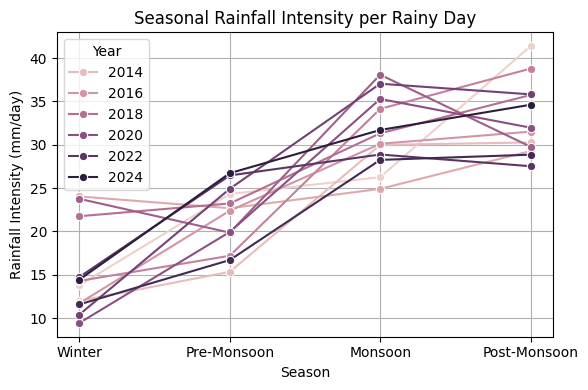

In [34]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=seasonal_stats, x='season', y='intensity_mm_per_rainy_day', hue='Year', marker='o')
plt.title("Seasonal Rainfall Intensity per Rainy Day")
plt.ylabel("Rainfall Intensity (mm/day)")
plt.xlabel("Season")
plt.grid(True)
plt.tight_layout()
plt.show()

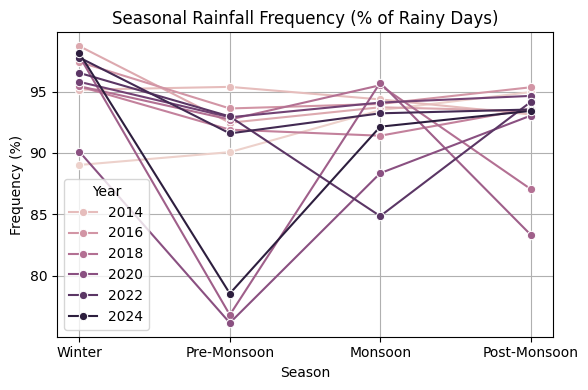

In [35]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=seasonal_stats, x='season', y='frequency_percent', hue='Year', marker='o')
plt.title("Seasonal Rainfall Frequency (% of Rainy Days)")
plt.ylabel("Frequency (%)")
plt.xlabel("Season")
plt.grid(True)
plt.tight_layout()
plt.show()

**MONTHLY RAINFALL**

In [36]:
monthly_stats = df.groupby(['Year', 'Month']).agg(
    total_rainfall_mm=('precipitation', 'sum'),
    rainy_days=('rainy_day', 'sum'),
    total_days=('precipitation', 'count')
).reset_index()

In [37]:
monthly_stats['intensity_mm_per_rainy_day'] = (
    monthly_stats['total_rainfall_mm'] / monthly_stats['rainy_days']
).replace([np.inf, -np.inf], np.nan)

monthly_stats['frequency_percent'] = (
    monthly_stats['rainy_days'] / monthly_stats['total_days']
) * 100

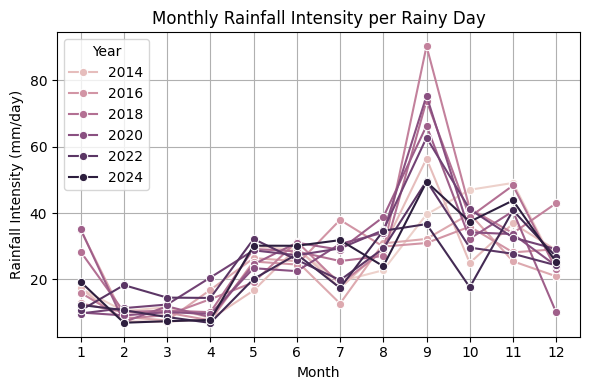

In [38]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=monthly_stats, x='Month', y='intensity_mm_per_rainy_day', hue='Year', marker='o')
plt.title("Monthly Rainfall Intensity per Rainy Day")
plt.ylabel("Rainfall Intensity (mm/day)")
plt.xlabel("Month")
plt.xticks(ticks=range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

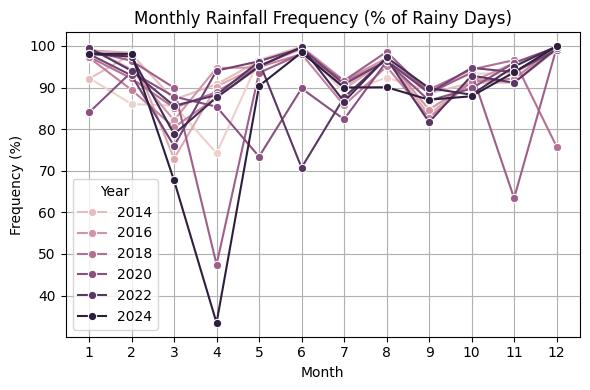

In [39]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=monthly_stats, x='Month', y='frequency_percent', hue='Year', marker='o')
plt.title("Monthly Rainfall Frequency (% of Rainy Days)")
plt.ylabel("Frequency (%)")
plt.xlabel("Month")
plt.xticks(ticks=range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

**DAILY RAINFALL INTENSITY CLASSIFICATION**

In [40]:
def classify_intensity(rain):
    if rain < 1:
        return "No Rain"
    elif 1 <= rain < 10:
        return "Light"
    elif 10 <= rain < 35:
        return "Moderate"
    else:
        return "Heavy"

In [41]:
df['intensity_class'] = df['precipitation'].apply(classify_intensity)

annual_stats = df.groupby('Year').agg(
    total_rainfall_mm=('precipitation', 'sum'),
    rainy_days=('precipitation', lambda x: (x > 1).sum()),
    heavy_rain_days=('precipitation', lambda x: (x > 35).sum()),
    mean_intensity=('precipitation', lambda x: x[x > 1].mean())
).reset_index()

print("\nAnnual Rainfall Statistics:")
print(annual_stats)


Annual Rainfall Statistics:
    Year  total_rainfall_mm  rainy_days  heavy_rain_days  mean_intensity
0   2013       1.060519e+06       40041            10104       26.474789
1   2014       8.492834e+05       32862             7664       25.834884
2   2015       8.196296e+05       33596             7226       24.385414
3   2016       9.435984e+05       35169             9367       26.821319
4   2017       9.370198e+05       33584             8634       27.887108
5   2018       1.091099e+06       37472            10077       29.104050
6   2019       9.838201e+05       31107             9709       31.606947
7   2020       1.010881e+06       34782             9216       29.037014
8   2021       1.081425e+06       34836            10318       31.032198
9   2022       9.296108e+05       36567             8827       25.399535
10  2023       7.315599e+05       29355             6241       24.909720
11  2024       1.040940e+06       36079             9870       28.837027


In [42]:
intensity_counts = df['intensity_class'].value_counts().reset_index()
intensity_counts.columns = ['Rainfall Category', 'Days']

print("\nIntensity Category-wise Day Count:")
print(intensity_counts)


Intensity Category-wise Day Count:
  Rainfall Category    Days
0          Moderate  178140
1             Light  130057
2             Heavy  107253
3           No Rain   17172


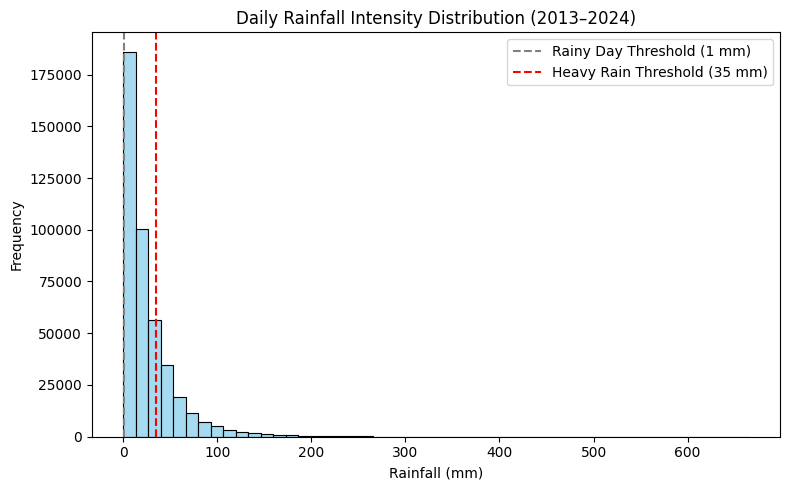

In [43]:
plt.figure(figsize=(8, 5))
sns.histplot(df['precipitation'], bins=50, kde=False, color='skyblue')
plt.axvline(1, color='gray', linestyle='--', label='Rainy Day Threshold (1 mm)')
plt.axvline(35, color='red', linestyle='--', label='Heavy Rain Threshold (35 mm)')
plt.title("Daily Rainfall Intensity Distribution (2013–2024)")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
df.head()

,date,label,precipitation,longitude,latitude,Year,Month,monthly_total_precip,monthly_mean_precip,monthly_anomaly,annual_total_precip,annual_total_anomaly,annual_mean_precip,Season,seasonal_total_precip,climatological_mean_precip,seasonal_anomaly,rainy_day,season,intensity_class
0,2024-01-01,932125,28.520353,93.649293,7.262650,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate
1,2024-01-01,510309,24.494017,93.649293,7.307566,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate
2,2024-01-01,805995,20.175045,93.649293,7.352482,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate
3,2024-01-01,131429,14.772869,93.694209,7.127903,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate
4,2024-01-01,292062,26.981068,93.694209,7.172819,2024,1,21383.638449,18.906842,0.855101,1.040940e+06,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate


# **SEASONAL RAINFALL PATTERN CLASSIFICATION (CLUSTERING)**

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
df['date'] = pd.to_datetime(df['date'])
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

In [47]:
def assign_season(month):
    if month in [1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Pre-Monsoon'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df['Season'] = df['Month'].apply(assign_season)

In [48]:
seasonal_totals = df.groupby(['Year', 'Season'])['precipitation'].sum().unstack().reset_index().fillna(0)
features_seasonal = ['Winter', 'Pre-Monsoon', 'Monsoon', 'Post-Monsoon']
scaled_seasonal = StandardScaler().fit_transform(seasonal_totals[features_seasonal])

kmeans_seasonal = KMeans(n_clusters=3, random_state=42)
seasonal_totals['Cluster'] = kmeans_seasonal.fit_predict(scaled_seasonal)

In [49]:
df = df.merge(seasonal_totals[['Year', 'Cluster']], on='Year', how='left')

In [50]:
# sns.pairplot(seasonal_totals, vars=features_seasonal, hue='Cluster', palette='Set2')
# plt.suptitle("Seasonal Rainfall Clustering (2013–2024)", y=1.02)
# plt.show()

In [51]:
print("Average Seasonal Rainfall by Cluster:")
print(seasonal_totals.groupby('Cluster')[features_seasonal].mean().round(1))

🌦️ Average Seasonal Rainfall by Cluster:
Season    Winter  Pre-Monsoon   Monsoon  Post-Monsoon
Cluster                                              
0        49168.4     157873.4  491075.0      246223.0
1        28446.1     143186.4  596484.3      252080.5
2        22209.8      67201.6  491207.1      209803.0


In [52]:
df.head()

,date,label,precipitation,longitude,latitude,Year,Month,monthly_total_precip,monthly_mean_precip,monthly_anomaly,...,annual_total_anomaly,annual_mean_precip,Season,seasonal_total_precip,climatological_mean_precip,seasonal_anomaly,rainy_day,season,intensity_class,Cluster
0,2024-01-01,932125,28.520353,93.649293,7.262650,2024,1,21383.638449,18.906842,0.855101,...,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate,1
1,2024-01-01,510309,24.494017,93.649293,7.307566,2024,1,21383.638449,18.906842,0.855101,...,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate,1
2,2024-01-01,805995,20.175045,93.649293,7.352482,2024,1,21383.638449,18.906842,0.855101,...,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate,1
3,2024-01-01,131429,14.772869,93.694209,7.127903,2024,1,21383.638449,18.906842,0.855101,...,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate,1
4,2024-01-01,292062,26.981068,93.694209,7.172819,2024,1,21383.638449,18.906842,0.855101,...,84324.669192,27.60895,Winter,366.4821,444.118614,-77.636514,True,Winter,Moderate,1


# **RAINFALL VARIABILITY INDEX (RVI)**

In [53]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
rvi_df = df.groupby(['latitude', 'longitude'])['precipitation'].agg(['mean', 'std', 'count']).reset_index()
rvi_df['RVI'] = rvi_df['std'] / rvi_df['mean']

In [55]:
rvi_df.replace([np.inf, -np.inf], np.nan, inplace=True)
rvi_df.dropna(subset=['RVI'], inplace=True)

In [56]:
scaler = MinMaxScaler()
rvi_df['RVI_norm'] = scaler.fit_transform(rvi_df[['RVI']])

In [57]:
def classify_rvi(rvi):
    if rvi < 0.2:
        return 'Low'
    elif rvi < 0.4:
        return 'Moderate'
    elif rvi < 0.6:
        return 'High'
    else:
        return 'Very High'

rvi_df['RVI_Category'] = rvi_df['RVI_norm'].apply(classify_rvi)

In [58]:
df = df.merge(rvi_df[['latitude', 'longitude', 'RVI', 'RVI_norm', 'RVI_Category']], on=['latitude', 'longitude'], how='left')

In [59]:
print("RVI Category Counts:")
print(rvi_df['RVI_Category'].value_counts())

RVI Category Counts:
RVI_Category
Moderate     161
High          76
Low           57
Very High     13
Name: count, dtype: int64


In [60]:
df.head()

,date,label,precipitation,longitude,latitude,Year,Month,monthly_total_precip,monthly_mean_precip,monthly_anomaly,...,seasonal_total_precip,climatological_mean_precip,seasonal_anomaly,rainy_day,season,intensity_class,Cluster,RVI,RVI_norm,RVI_Category
0,2024-01-01,932125,28.520353,93.649293,7.262650,2024,1,21383.638449,18.906842,0.855101,...,366.4821,444.118614,-77.636514,True,Winter,Moderate,1,0.994152,0.231156,Moderate
1,2024-01-01,510309,24.494017,93.649293,7.307566,2024,1,21383.638449,18.906842,0.855101,...,366.4821,444.118614,-77.636514,True,Winter,Moderate,1,0.901943,0.106185,Low
2,2024-01-01,805995,20.175045,93.649293,7.352482,2024,1,21383.638449,18.906842,0.855101,...,366.4821,444.118614,-77.636514,True,Winter,Moderate,1,0.969444,0.197669,Low
3,2024-01-01,131429,14.772869,93.694209,7.127903,2024,1,21383.638449,18.906842,0.855101,...,366.4821,444.118614,-77.636514,True,Winter,Moderate,1,0.942208,0.160756,Low
4,2024-01-01,292062,26.981068,93.694209,7.172819,2024,1,21383.638449,18.906842,0.855101,...,366.4821,444.118614,-77.636514,True,Winter,Moderate,1,0.970011,0.198438,Low


# **RAINFALL FORECASTING**

In [61]:
# !pip install tensorflow

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/Andaman_Rainfall_Analytics/CHIRPS_Cleaned1.csv", parse_dates=["date"])

# Step 1: Preprocessing
# Ensure 'Year' and 'Month' columns are present
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# Group by year and month and compute average monthly precipitation
monthly_data = df.groupby(["Year", "Month"]).agg({"precipitation": "mean"}).reset_index()
monthly_data["Date"] = pd.to_datetime(monthly_data["Year"].astype(str) + "-" + monthly_data["Month"].astype(str) + "-01")

# Sort by Date
monthly_data = monthly_data.sort_values("Date")

# Step 2: Scaling
scaler = MinMaxScaler()
monthly_data["precip_scaled"] = scaler.fit_transform(monthly_data[["precipitation"]])

# Step 3: Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12  # 12 months = 1 year
X, y = create_sequences(monthly_data["precip_scaled"].values, sequence_length)

# Reshape for LSTM: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [64]:
# Step 4: Train-Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [65]:
# Step 5: Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [67]:
# Step 6: Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 517ms/step - loss: 0.0911 - val_loss: 0.0285
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0422 - val_loss: 0.0299
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0411 - val_loss: 0.0262
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0447 - val_loss: 0.0272
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0506 - val_loss: 0.0258
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0345 - val_loss: 0.0254
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0498 - val_loss: 0.0251
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0373 - val_loss: 0.0249
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0370 - val_loss: 0.0255
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0393 - val_loss: 0.0243
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0522 - val_loss: 0.0250
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0302 - val_

In [68]:
# Step 7: Predictions and Inverse Scaling
predicted = model.predict(X_test)
predicted_precip = scaler.inverse_transform(predicted)
actual_precip = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


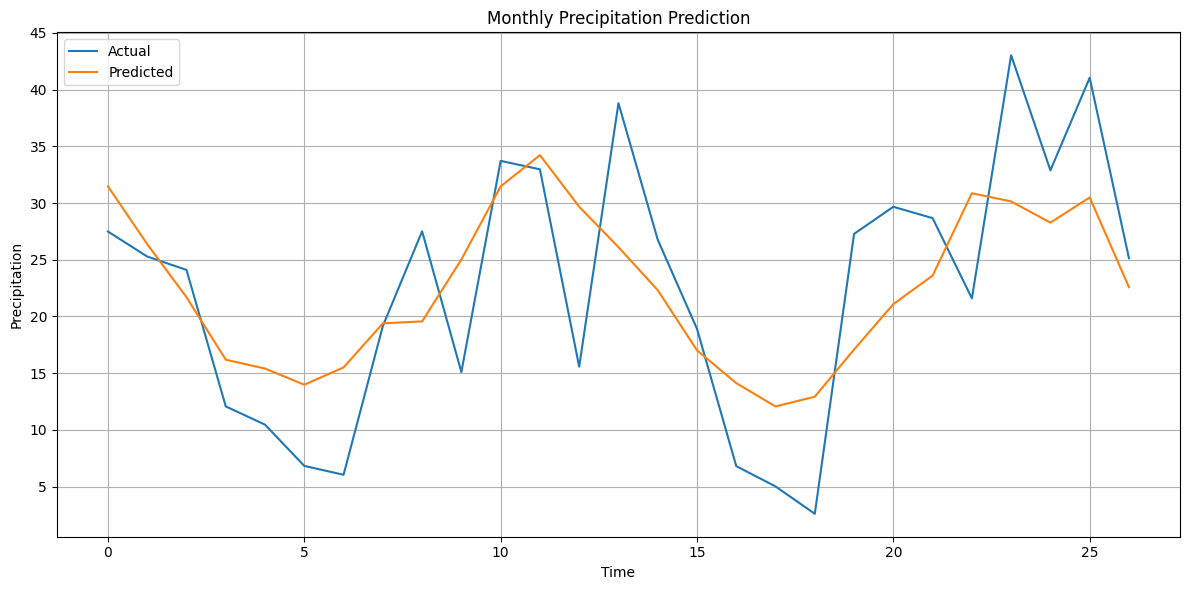

In [69]:
# Step 8: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(actual_precip, label="Actual")
plt.plot(predicted_precip, label="Predicted")
plt.title("Monthly Precipitation Prediction")
plt.xlabel("Time")
plt.ylabel("Precipitation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
dates = pd.date_range(start="2024-03-01", periods=len(predicted_precip), freq="MS")

forecast_df_aligned = pd.DataFrame({
    "Forecasted Rainfall (mm)": predicted_precip.flatten(),
    "Actual Rainfall (mm)": actual_precip.flatten()
}, index=dates)

print("Forecasted Rainfall for Next 12 Months:")
print(forecast_df_aligned[['Forecasted Rainfall (mm)']])

print("\nActual Rainfall for Corresponding Months:")
print(forecast_df_aligned[['Actual Rainfall (mm)']])

Forecasted Rainfall for Next 12 Months:
            Forecasted Rainfall (mm)
2024-03-01                 31.470110
2024-04-01                 26.374193
2024-05-01                 21.696949
2024-06-01                 16.185661
2024-07-01                 15.406281
2024-08-01                 13.978843
2024-09-01                 15.505820
2024-10-01                 19.386608
2024-11-01                 19.564297
2024-12-01                 25.023510
2025-01-01                 31.463223
2025-02-01                 34.221893
2025-03-01                 29.672487
2025-04-01                 26.108385
2025-05-01                 22.317112
2025-06-01                 17.012514
2025-07-01                 14.118911
2025-08-01                 12.063455
2025-09-01                 12.926835
2025-10-01                 17.085253
2025-11-01                 21.085604
2025-12-01                 23.600914
2026-01-01                 30.858351
2026-02-01                 30.140554
2026-03-01                 28.26857

# **SPATIAL VISUALIZATION**

In [71]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.7 MB/s eta 0:00:00


In [72]:
import geopandas as gpd
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [73]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

In [74]:
shapefile_path = '/content/drive/MyDrive/Andaman_Rainfall_Analytics/ROI_Shapefile/Andaman/Andaman.shp'
gdf_region = gpd.read_file(shapefile_path)
gdf_region = gdf_region.to_crs(epsg=4326)

In [75]:
df_rain = pd.read_csv('/content/drive/MyDrive/Andaman_Rainfall_Analytics/CHIRPS_Cleaned1.csv')

In [76]:
geometry = [Point(xy) for xy in zip(df_rain['longitude'], df_rain['latitude'])]
gdf_rain = gpd.GeoDataFrame(df_rain, geometry=geometry, crs='EPSG:4326')

In [77]:
gdf_rain_clip = gpd.sjoin(gdf_rain, gdf_region, predicate='within')
print(f"Points within the shapefile region: {len(gdf_rain_clip)}")

Points within the shapefile region: 345061


In [78]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

In [79]:
def assign_season(month):
    if month in [1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Pre-monsoon'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-monsoon'

df['season'] = df['month'].map(assign_season)

In [80]:
seasonal_rainfall1 = df.groupby(['label', 'season'])['precipitation'].sum().reset_index()
rainfall_pivot = seasonal_rainfall1.pivot(index='label', columns='season', values='precipitation').fillna(0)
rainfall_pivot.reset_index(inplace=True)

In [81]:
station_coords = df[['label', 'latitude', 'longitude']].drop_duplicates()
rainfall_pivot = rainfall_pivot.merge(station_coords, on='label', how='left')

In [82]:
kmeans = KMeans(n_clusters=4, random_state=42)
rainfall_pivot['cluster_label'] = kmeans.fit_predict(
    rainfall_pivot[['Monsoon', 'Pre-monsoon', 'Post-monsoon', 'Winter']]
)

In [83]:
cluster_mean = rainfall_pivot.groupby('cluster_label')[['Winter', 'Pre-monsoon', 'Monsoon', 'Post-monsoon']].mean()
print("=== Cluster Rainfall Pattern Summary ===")
print(cluster_mean)

=== Cluster Rainfall Pattern Summary ===
                    Winter  Pre-monsoon       Monsoon  Post-monsoon
cluster_label                                                      
0              1542.686848  3961.873933  19033.935600   5425.908561
1               914.662650  6537.414602  20998.776519  16556.810717
2               844.152113  6825.249146  29913.062463   9434.474988
3              2302.832481  4012.865716  11194.396758   9987.067607


In [84]:
label_map = {
    0: 'High Monsoon Rainfall',
    1: 'Pre-monsoon Peaks',
    2: 'Balanced with Post-monsoon',
    3: 'Extreme Monsoon Dominance'
}
rainfall_pivot['cluster_desc'] = rainfall_pivot['cluster_label'].map(label_map)

In [85]:
geometry = gpd.points_from_xy(rainfall_pivot['longitude'], rainfall_pivot['latitude'])
rainfall_gdf = gpd.GeoDataFrame(rainfall_pivot, geometry=geometry, crs='EPSG:4326')

In [86]:
andaman_shp = gpd.read_file('/content/drive/MyDrive/Andaman_Rainfall_Analytics/ROI_Shapefile/Andaman/Andaman.shp')

In [87]:
cluster_colors = {
    0: '#66c2a5',
    1: '#fc8d62',
    2: '#8da0cb',
    3: '#e78ac3'
}
rainfall_gdf['color'] = rainfall_gdf['cluster_label'].map(cluster_colors)

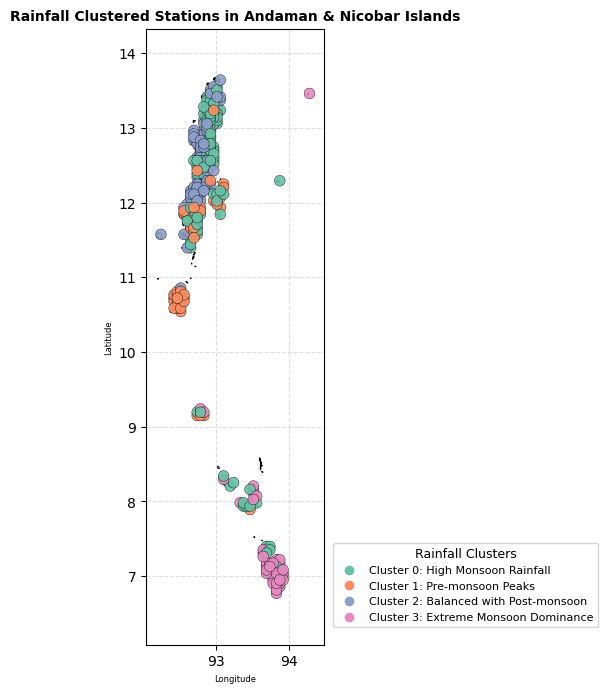

In [88]:
fig, ax = plt.subplots(figsize=(6.5, 8))

andaman_shp.plot(ax=ax, color='white', edgecolor='black', linewidth=0.6)

rainfall_gdf.plot(
    ax=ax,
    color=rainfall_gdf['color'],
    markersize=60,
    edgecolor='black',
    linewidth=0.3,
    alpha=0.9
)

xmin, ymin, xmax, ymax = rainfall_gdf.total_bounds
x_pad = (xmax - xmin) * 0.1
y_pad = (ymax - ymin) * 0.1

ax.set_xlim(xmin - x_pad, xmax + x_pad)
ax.set_ylim(ymin - y_pad, ymax + y_pad)

plt.title('Rainfall Clustered Stations in Andaman & Nicobar Islands', fontsize=10, fontweight='bold')
plt.xlabel('Longitude', fontsize=6)
plt.ylabel('Latitude', fontsize=6)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cluster 0: High Monsoon Rainfall', markerfacecolor=cluster_colors[0], markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Cluster 1: Pre-monsoon Peaks', markerfacecolor=cluster_colors[1], markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Cluster 2: Balanced with Post-monsoon', markerfacecolor=cluster_colors[2], markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Cluster 3: Extreme Monsoon Dominance', markerfacecolor=cluster_colors[3], markersize=8)
]

legend = plt.legend(
    handles=legend_elements,
    title="Rainfall Clusters",
    title_fontsize=9,
    fontsize=8,
    loc='lower left',
    bbox_to_anchor=(1.02, 0.02),
    frameon=True
)

ax.grid(True, linestyle='--', alpha=0.4)

plt.subplots_adjust(right=0.75)

plt.show()

# **INTERPOLATION**

In [89]:
!pip install geopandas rasterio shapely matplotlib scipy

In [90]:
!pip install rasterio

In [91]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.mask import mask
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import json
import os

In [92]:
import os
seasons = ['Monsoon', 'Post-monsoon', 'Pre-monsoon', 'Winter']
output_dir = "/content/drive/MyDrive/Andaman_Rainfall_Analytics"
os.makedirs(output_dir, exist_ok=True)

In [93]:
andaman_geom = [json.loads(andaman_shp.to_json())['features'][0]['geometry']]
bounds = andaman_shp.total_bounds
lon_min, lat_min, lon_max, lat_max = bounds[0]-0.5, bounds[1]-0.5, bounds[2]+0.5, bounds[3]+0.5

In [94]:
grid_lon = np.linspace(lon_min, lon_max, 500)
grid_lat = np.linspace(lat_min, lat_max, 500)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)

In [95]:
transform = from_origin(grid_lon.min(), grid_lat.max(),
                        (grid_lon.max() - grid_lon.min()) / grid_x.shape[1],
                        (grid_lat.max() - grid_lat.min()) / grid_y.shape[0])

In [96]:
masked_data = []
extents = []

In [97]:
for season in seasons:
    print(f"Processing: {season}")
    col = season

    valid = rainfall_gdf[rainfall_gdf[col] > 0]
    points = valid[['longitude', 'latitude']].values
    values = valid[col].values

    if len(points) < 4:
        print(f"Only {len(points)} valid points for {season}. Using 'nearest' method.")
        method = 'nearest'
    else:
        method = 'cubic'

    grid_z_cubic = griddata(points, values, (grid_x, grid_y), method=method)

    if method == 'cubic':
        grid_z_nearest = griddata(points, values, (grid_x, grid_y), method='nearest')
        grid_z = np.where(np.isnan(grid_z_cubic), grid_z_nearest, grid_z_cubic)
    else:
        grid_z = grid_z_cubic

    interp_path = os.path.join(output_dir, f"{season}_interpolated.tif")
    with rasterio.open(interp_path, 'w', driver='GTiff',
                       height=grid_z.shape[0], width=grid_z.shape[1],
                       count=1, dtype=grid_z.dtype,
                       crs='EPSG:4326', transform=transform) as dst:
        dst.write(grid_z, 1)

    with rasterio.open(interp_path) as src:
        out_image, out_transform = mask(src, andaman_geom, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

    clipped_path = os.path.join(output_dir, f"{season}_clipped.tif")
    with rasterio.open(clipped_path, "w", **out_meta) as dest:
        dest.write(out_image)

    masked = np.ma.masked_where(out_image[0] <= 0, out_image[0])
    extent = [
        out_transform[2],
        out_transform[2] + out_transform[0] * masked.shape[1],
        out_transform[5] + out_transform[4] * masked.shape[0],
        out_transform[5]
    ]
    masked_data.append(masked)
    extents.append(extent)

print("All rasters interpolated, clipped, and saved.")

Processing: Monsoon
Processing: Post-monsoon
Processing: Pre-monsoon
Processing: Winter
All rasters interpolated, clipped, and saved.


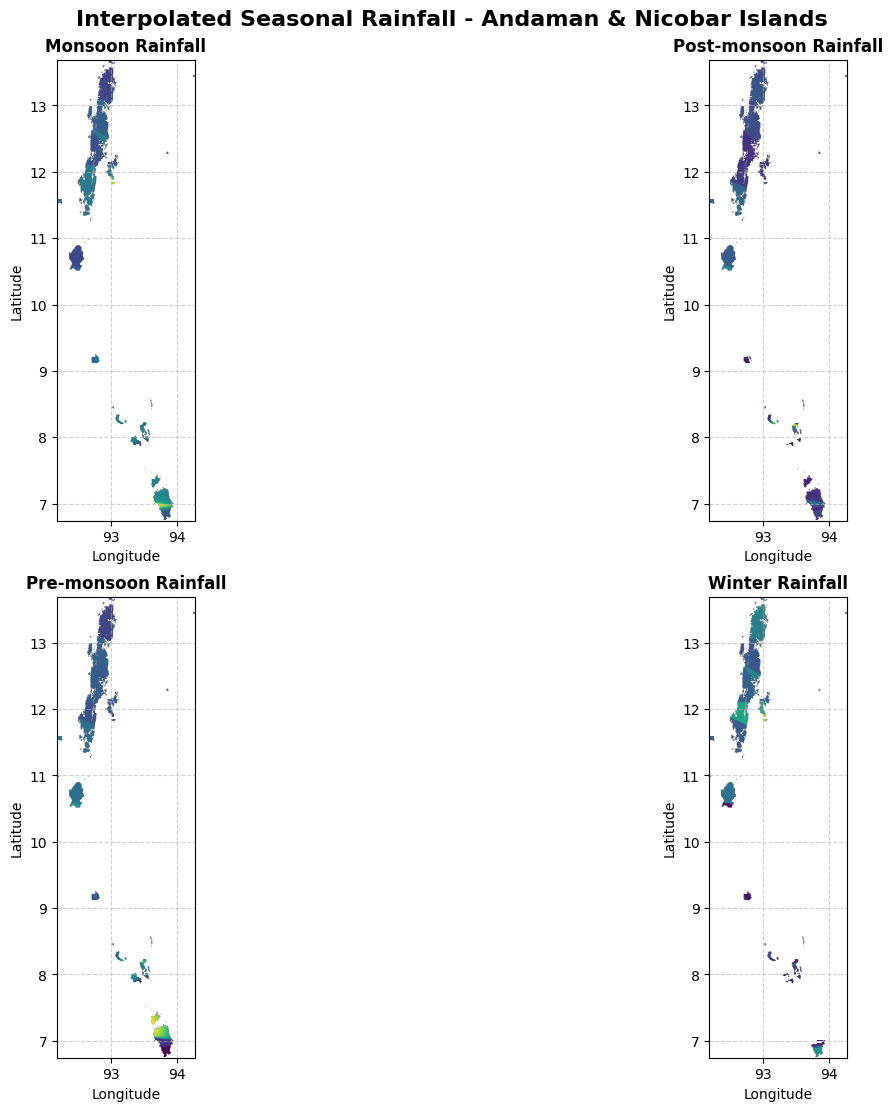

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Use constrained_layout instead of tight_layout
fig, axs = plt.subplots(2, 2, figsize=(13, 11), constrained_layout=True)
axs = axs.flatten()

# Store one of the image handles to use for colorbar
im = None

for i, season in enumerate(seasons):
    im = axs[i].imshow(masked_data[i], cmap='viridis', extent=extents[i], origin='upper')
    axs[i].set_title(f"{season} Rainfall", fontsize=12, weight='bold')
    axs[i].set_xlabel("Longitude")
    axs[i].set_ylabel("Latitude")
    axs[i].grid(True, linestyle='--', alpha=0.6)



# Add suptitle after everything is placed
fig.suptitle("Interpolated Seasonal Rainfall - Andaman & Nicobar Islands", fontsize=16, weight='bold')

plt.show()



**ANIMATING THE INTERPOLATION**

In [99]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import rasterio
import numpy as np
import os

# Define paths
seasons = ['Monsoon', 'Post-monsoon', 'Pre-monsoon', 'Winter']
folder = "/content/drive/MyDrive/Andaman_Rainfall_Analytics"
clipped_paths = [os.path.join(folder, f"{season}_clipped.tif") for season in seasons]

# Read rasters, crop to valid rainfall, calculate extent
masked_data = []
extents = []

for path in clipped_paths:
    with rasterio.open(path) as src:
        data = src.read(1)
        transform = src.transform

        # Mask zero or negative values
        mask = data > 0
        if np.any(mask):
            rows, cols = np.where(mask)

            # Crop data and update transform
            row_min, row_max = rows.min(), rows.max()
            col_min, col_max = cols.min(), cols.max()
            cropped = data[row_min:row_max + 1, col_min:col_max + 1]
            masked = np.ma.masked_where(cropped <= 0, cropped)
            masked_data.append(masked)

            # Recalculate extent for cropped data
            x_min = transform[2] + col_min * transform[0]
            x_max = transform[2] + (col_max + 1) * transform[0]
            y_max = transform[5] + row_min * transform[4]
            y_min = transform[5] + (row_max + 1) * transform[4]
            extent = [x_min, x_max, y_min, y_max]
            extents.append(extent)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))  # Tall aspect
img = ax.imshow(masked_data[0], cmap='Spectral', extent=extents[0])
title = ax.set_title("Seasonal Rainfall \nSeason: Monsoon", fontsize=14, weight='bold', loc='center')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")



# Update function for animation
def update(frame):
    img.set_data(masked_data[frame])
    img.set_extent(extents[frame])
    title.set_text(f"Seasonal Rainfall \nSeason: {seasons[frame]}")
    return img, title

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(seasons), interval=1500, blit=False)

# Save
gif_path = os.path.join(folder, "Seasonal_Rainfall_Andaman.gif")
ani.save(gif_path, writer='pillow', dpi=120)
plt.close()

print(f"Animation saved to: {gif_path}")

Animation saved to: /content/drive/MyDrive/Andaman_Rainfall_Analytics/Seasonal_Rainfall_Andaman.gif


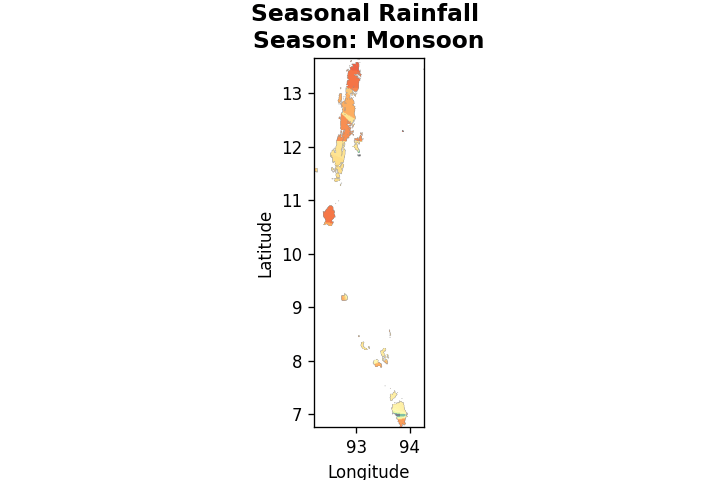

In [100]:
from IPython.display import Image
Image(filename=gif_path)